# Support Vector Machine on Mushroom Dataset

### Dataset
The Mushroom dataset contains 2000 entries with 26 columns. The features include categorical attributes like `cap_shape`, `cap_surface`, and `odor`, among others, along with numerical attributes `stalk_height` and `cap_diameter`. The target variable is `class`.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

### Exploratory Data Analysis (EDA)

#### 1. Loading the Mushroom dataset

In [3]:
mushrooms = pd.read_csv('mushroom.csv')
mushrooms.head()

,Unnamed: 0,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat,class,stalk_height,cap_diameter
0,1167,sunken,scaly,white,no,anise,descending,distant,broad,pink,...,partial,brown,two,sheathing,chocolate,clustered,waste,poisonous,14.276173,5.054983
1,1037,sunken,fibrous,red,no,anise,notched,crowded,narrow,chocolate,...,universal,brown,two,sheathing,brown,numerous,waste,edible,3.952715,19.068319
2,309,flat,grooves,purple,yes,foul,descending,crowded,broad,purple,...,universal,yellow,two,sheathing,purple,abundant,waste,poisonous,9.054265,7.205884
3,282,bell,scaly,pink,yes,fishy,notched,close,broad,orange,...,partial,yellow,two,cobwebby,green,clustered,grasses,poisonous,5.226499,20.932692
4,820,flat,smooth,yellow,yes,musty,free,crowded,narrow,orange,...,universal,white,none,none,yellow,clustered,urban,poisonous,14.037532,12.545245


In [4]:
mushrooms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                2000 non-null   int64  
 1   cap_shape                 2000 non-null   object 
 2   cap_surface               2000 non-null   object 
 3   cap_color                 2000 non-null   object 
 4   bruises                   2000 non-null   object 
 5   odor                      2000 non-null   object 
 6   gill_attachment           2000 non-null   object 
 7   gill_spacing              2000 non-null   object 
 8   gill_size                 2000 non-null   object 
 9   gill_color                2000 non-null   object 
 10  stalk_shape               2000 non-null   object 
 11  stalk_root                2000 non-null   object 
 12  stalk_surface_above_ring  2000 non-null   object 
 13  stalk_surface_below_ring  2000 non-null   object 
 14  stalk_co

In [5]:
mushrooms['class'].value_counts()

class
poisonous    1400
edible        600
Name: count, dtype: int64

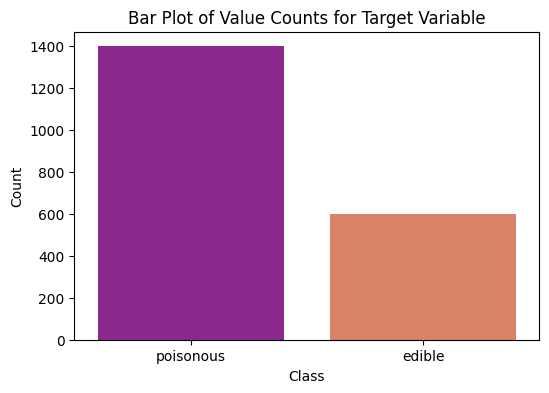

In [6]:
plt.figure(figsize=(6, 4))
sns.barplot(x=mushrooms['class'].value_counts().index, y=mushrooms['class'].value_counts().values, palette='plasma')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Bar Plot of Value Counts for Target Variable')
plt.show()

The data is highly imbalanced.

In [7]:
mushrooms.describe()

,Unnamed: 0,stalk_height,cap_diameter
count,2000.000000,2000.000000,2000.000000
mean,624.974000,8.449118,12.314345
std,375.091938,3.697217,7.048845
min,0.000000,2.000000,1.000000
25%,290.000000,5.291009,5.723521
50%,607.000000,8.318596,12.124902
75%,957.250000,11.781272,18.698605
max,1279.000000,15.095066,25.000054


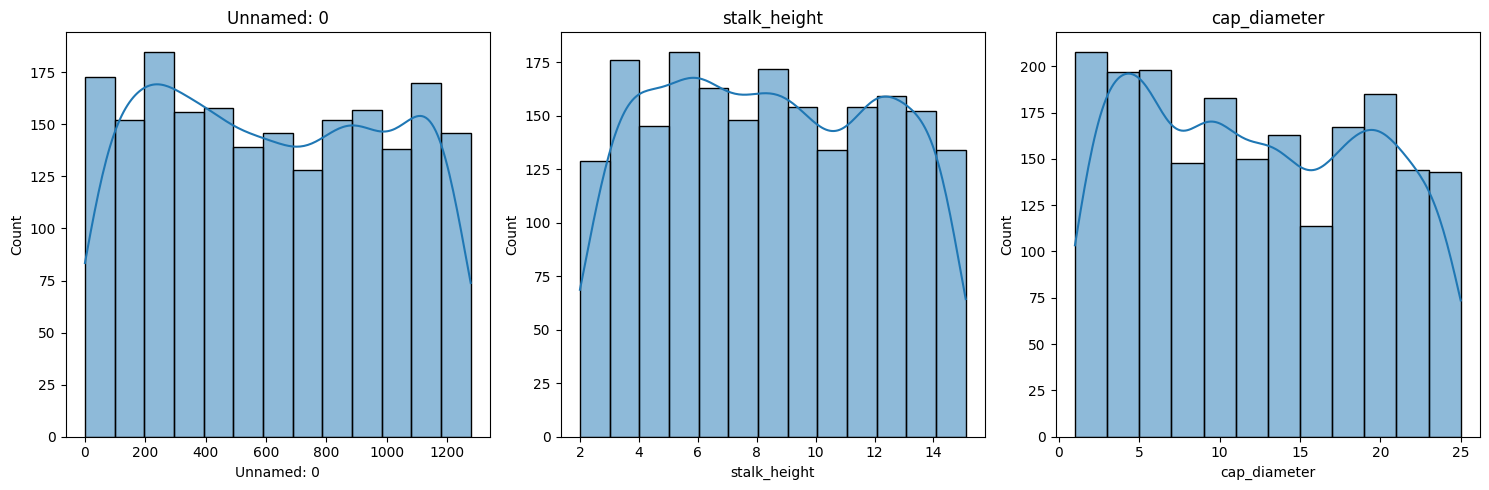

In [8]:
# Histograms for numerical features

data = mushrooms[['Unnamed: 0', 'stalk_height', 'cap_diameter']]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate through numerical columns and plot
for i, col in enumerate(data):
    sns.histplot(data[col], kde=True, ax=axes[i])
    axes[i].set_title(col)

# Adjust layout
plt.tight_layout()
plt.show()

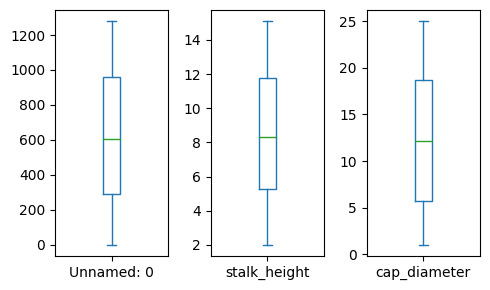

In [9]:
# Box plots
data.plot(kind='box', subplots=True, layout=(1, 3), figsize=(5, 3), sharex=False, sharey=False)
plt.tight_layout()
plt.show()

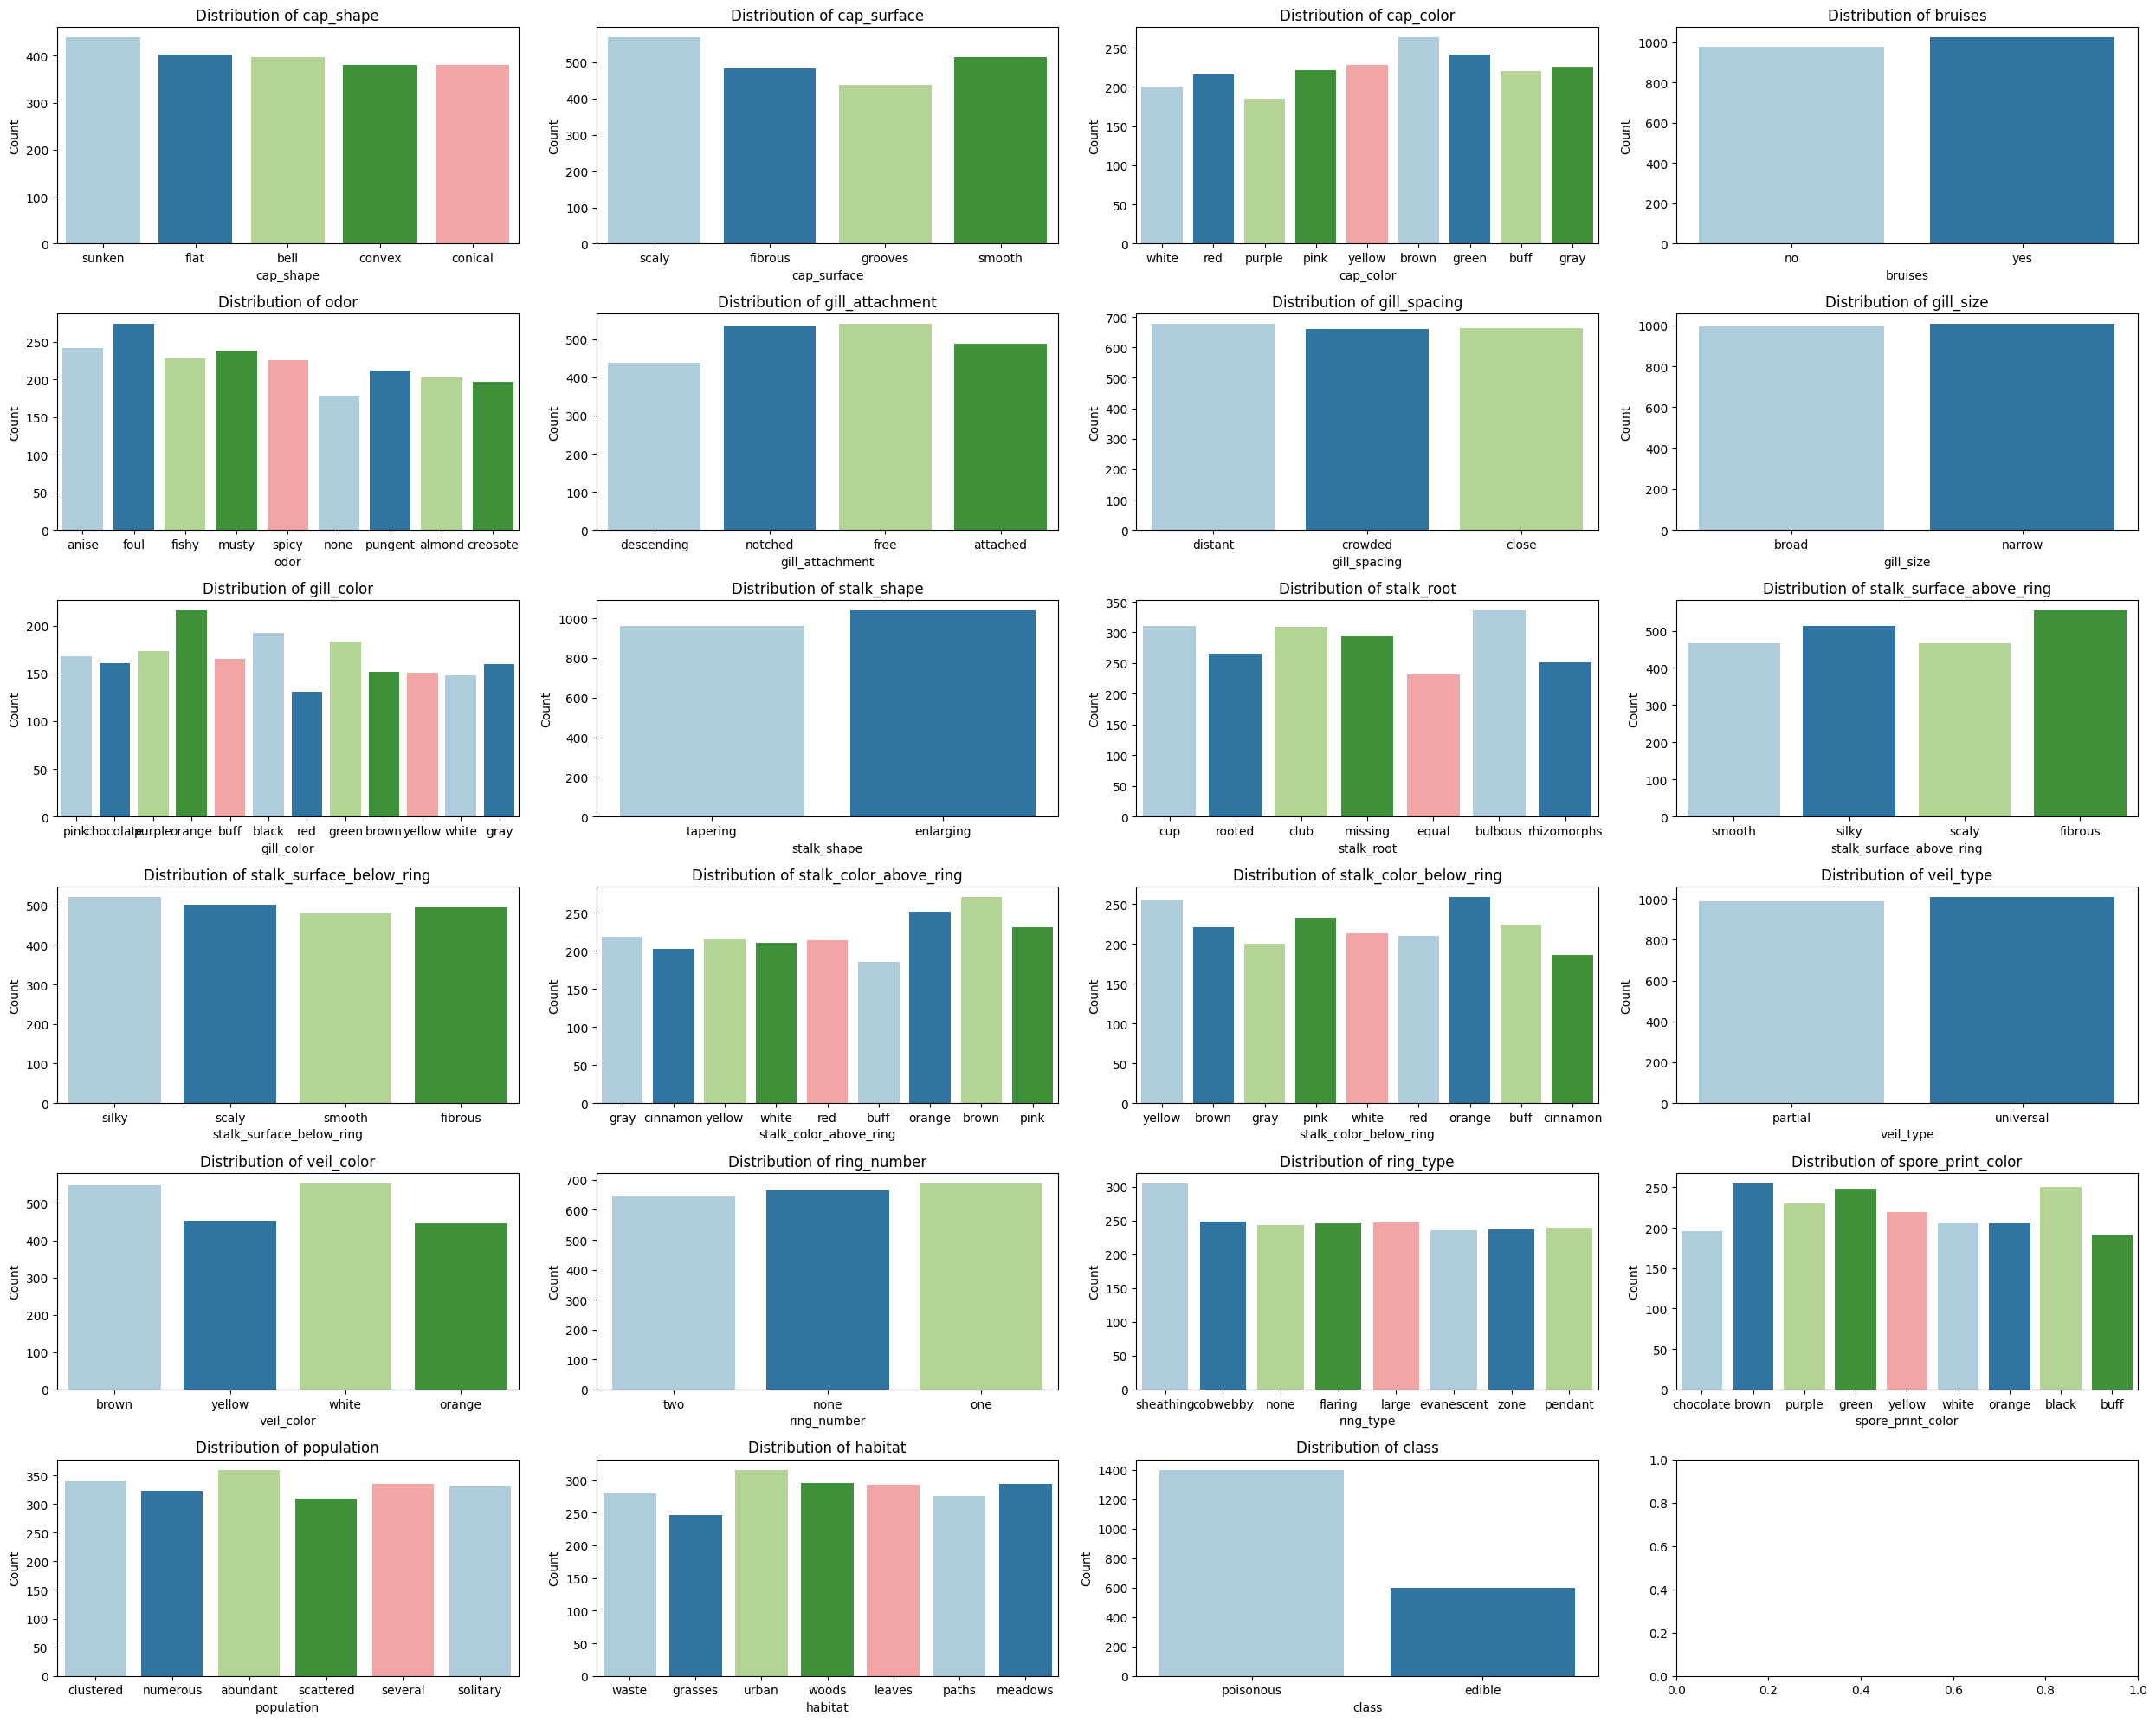

In [10]:
# Identify categorical columns
categorical_columns = mushrooms.select_dtypes(include=['object', 'category', 'bool']).columns

# Define a color palette
palette = sns.color_palette("Paired", 5)

# Plot bar graphs for each categorical column
num_plots = len(categorical_columns)
fig, axes = plt.subplots(6, 4, figsize=(25, 20))
axes = axes.flatten()

for i, col in enumerate(categorical_columns):
    # Get the unique categories for the column
    unique_categories = mushrooms[col].unique()
    # Generate a palette with the same number of colors as unique categories
    category_palette = sns.color_palette(palette, len(unique_categories))
    sns.countplot(data=mushrooms, x=col, ax=axes[i], palette=category_palette)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

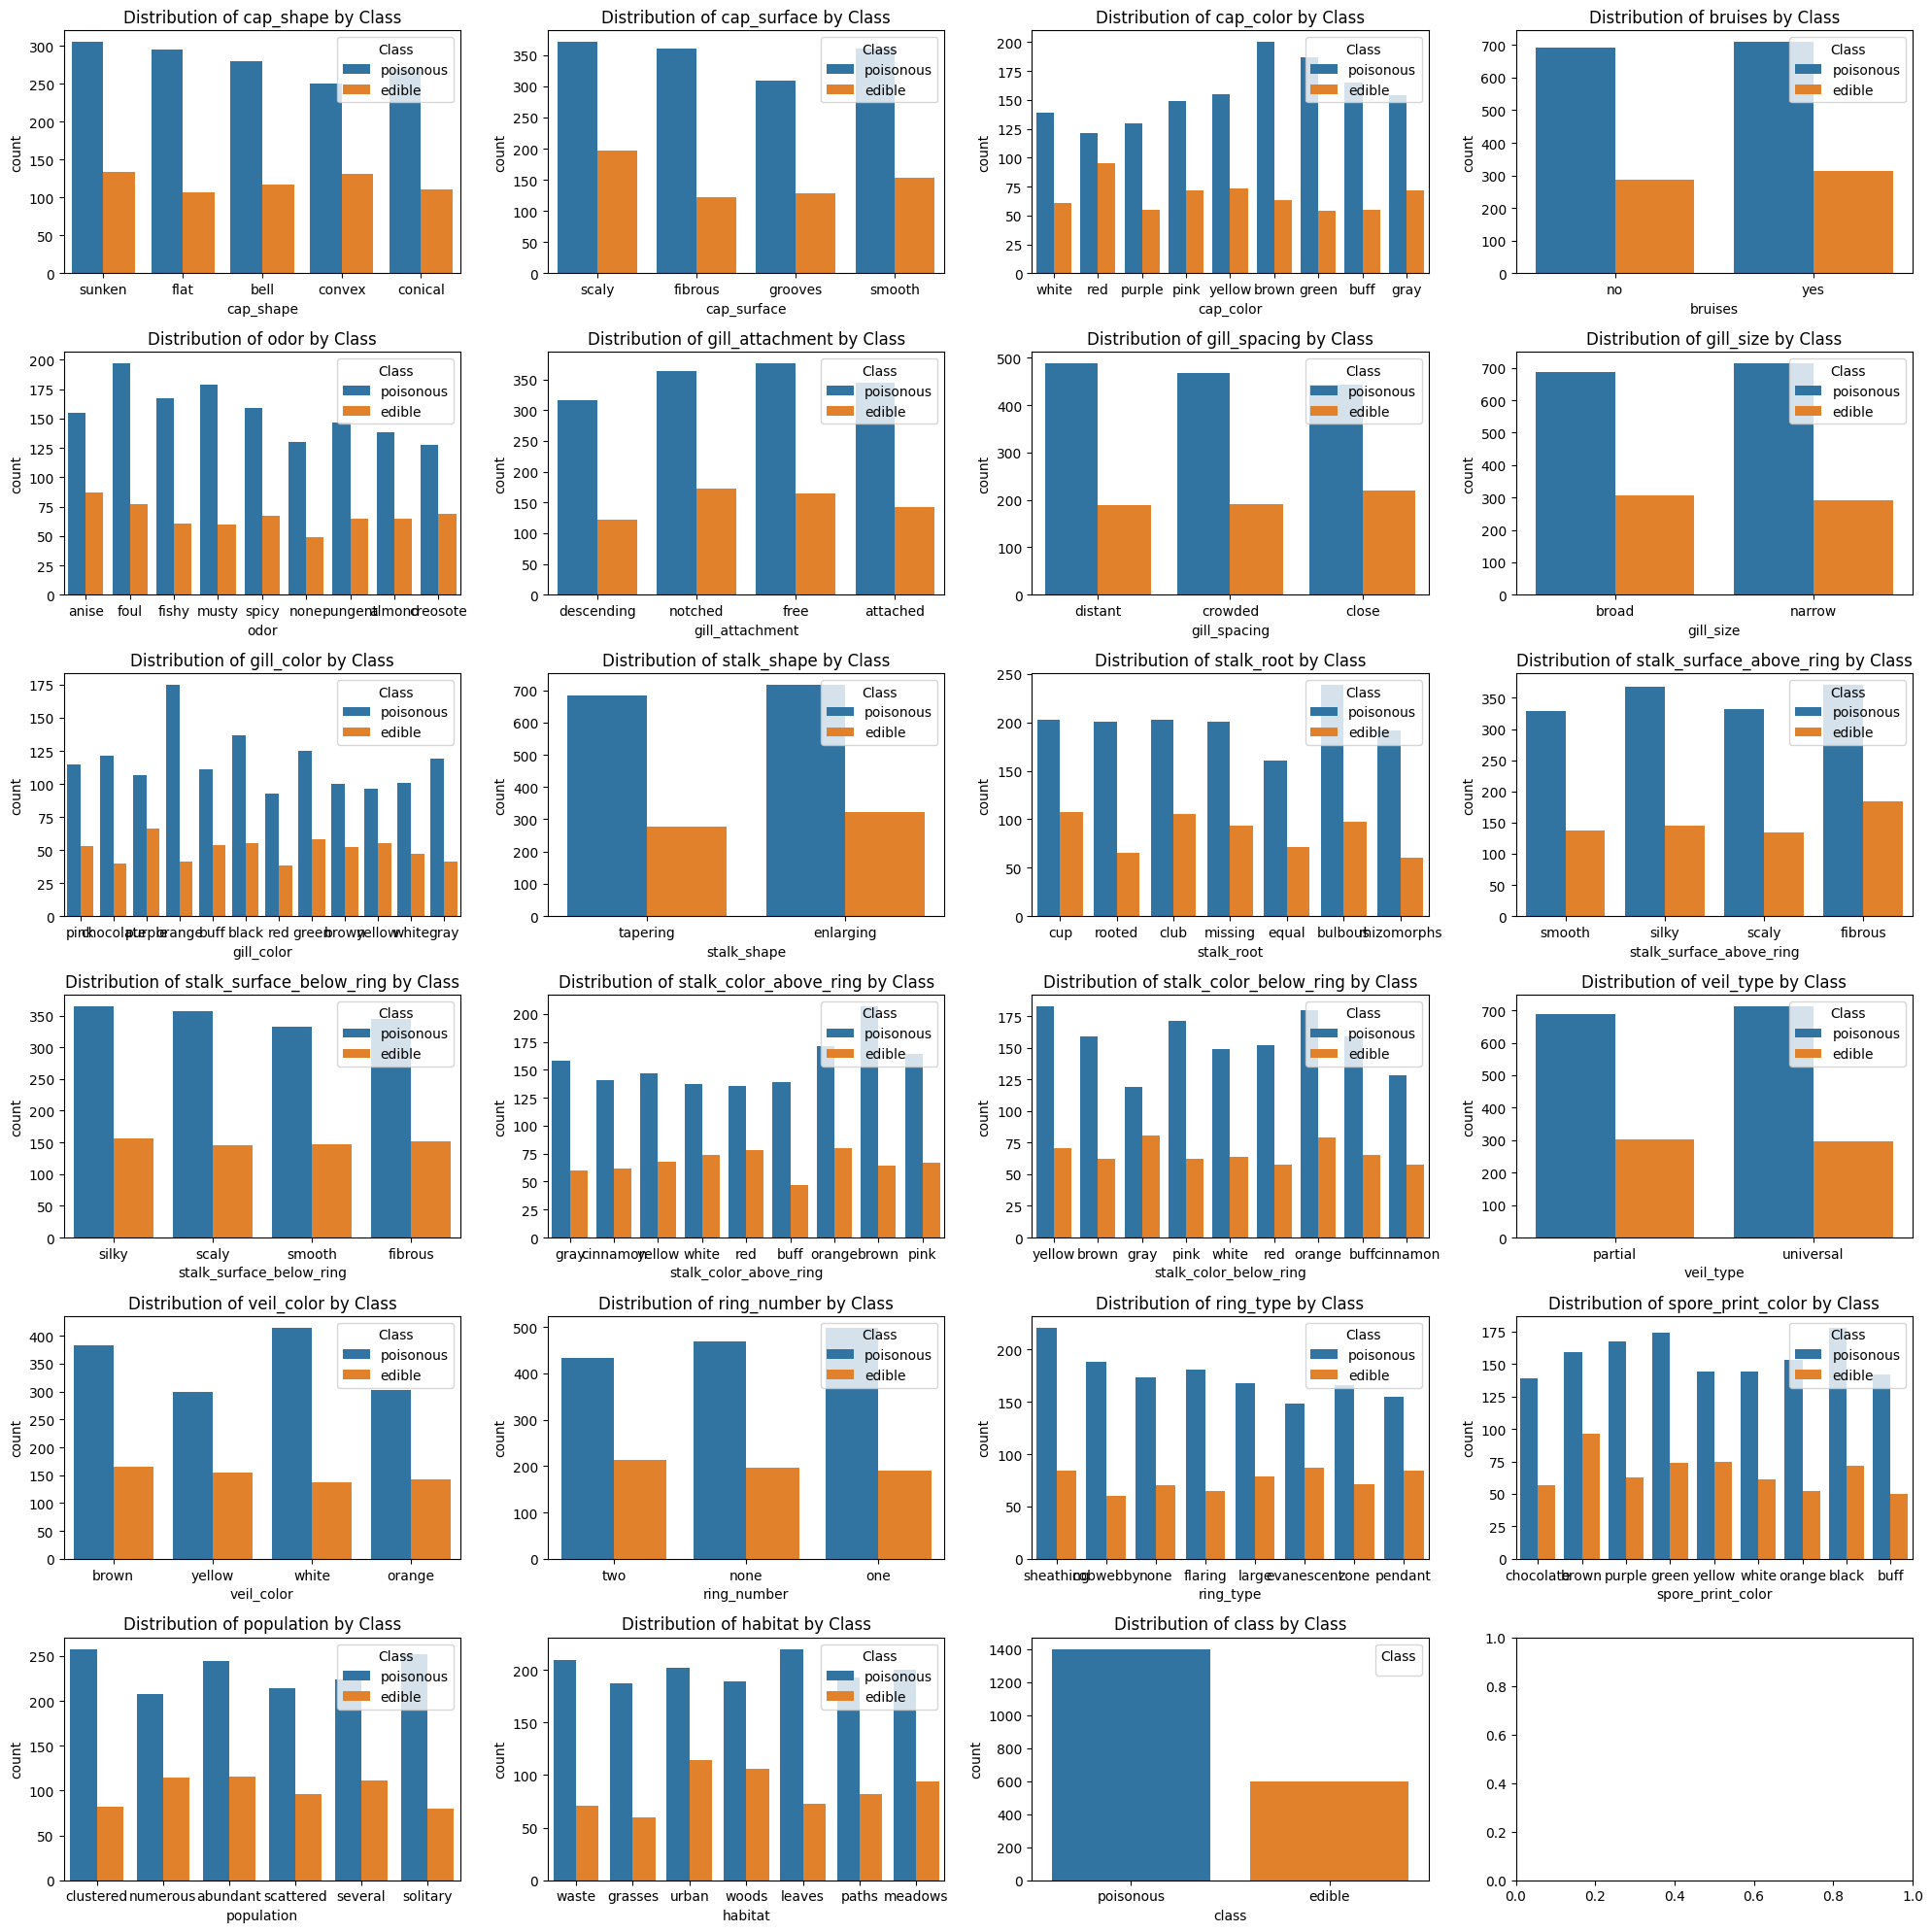

In [11]:
# Plot distribution of each categorical variable with respect to the class
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(20, 20))
axes = axes.flatten()

for idx, column in enumerate(categorical_columns):
    sns.countplot(x=column, hue='class', data=mushrooms, ax=axes[idx])
    axes[idx].set_title(f'Distribution of {column} by Class')
    axes[idx].legend(title='Class', loc='upper right')

plt.tight_layout()
plt.show()

### Data Preprocessing

**Encoding Categorical Variables**

In [12]:
# Encode categorical variables
label_encoders = {}
for column in mushrooms.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    mushrooms[column] = label_encoders[column].fit_transform(mushrooms[column])

mushrooms.head()

,Unnamed: 0,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat,class,stalk_height,cap_diameter
0,1167,4,2,7,0,1,1,2,0,7,...,0,0,2,6,3,1,5,1,14.276173,5.054983
1,1037,4,0,6,0,1,3,1,1,3,...,1,0,2,6,1,2,5,0,3.952715,19.068319
2,309,3,1,5,1,4,1,1,0,8,...,1,3,2,6,6,0,5,1,9.054265,7.205884
3,282,0,2,4,1,3,3,0,0,6,...,0,3,2,0,4,1,0,1,5.226499,20.932692
4,820,3,3,8,1,5,2,1,1,6,...,1,2,0,4,8,1,4,1,14.037532,12.545245


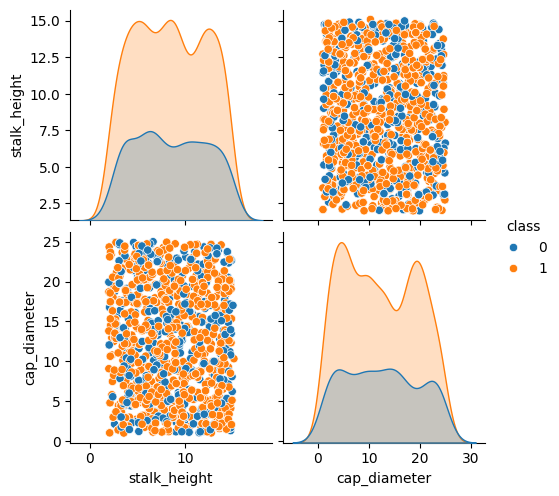

In [13]:
# Pair plot for numerical features
sns.pairplot(mushrooms[['stalk_height', 'cap_diameter', 'class']], hue='class')
plt.show()

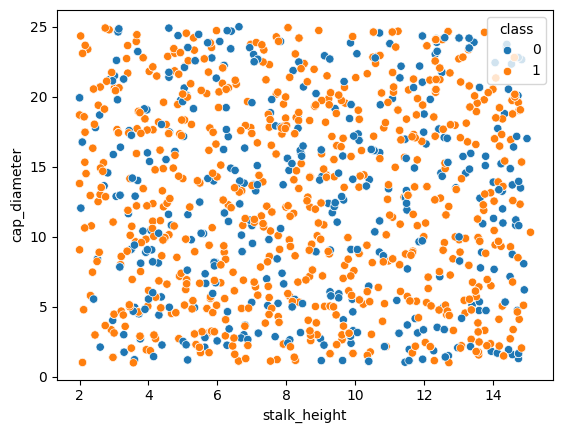

In [14]:
# Scatter plot for numerical features
sns.scatterplot(x='stalk_height', y='cap_diameter', hue='class', data=mushrooms)
plt.show()

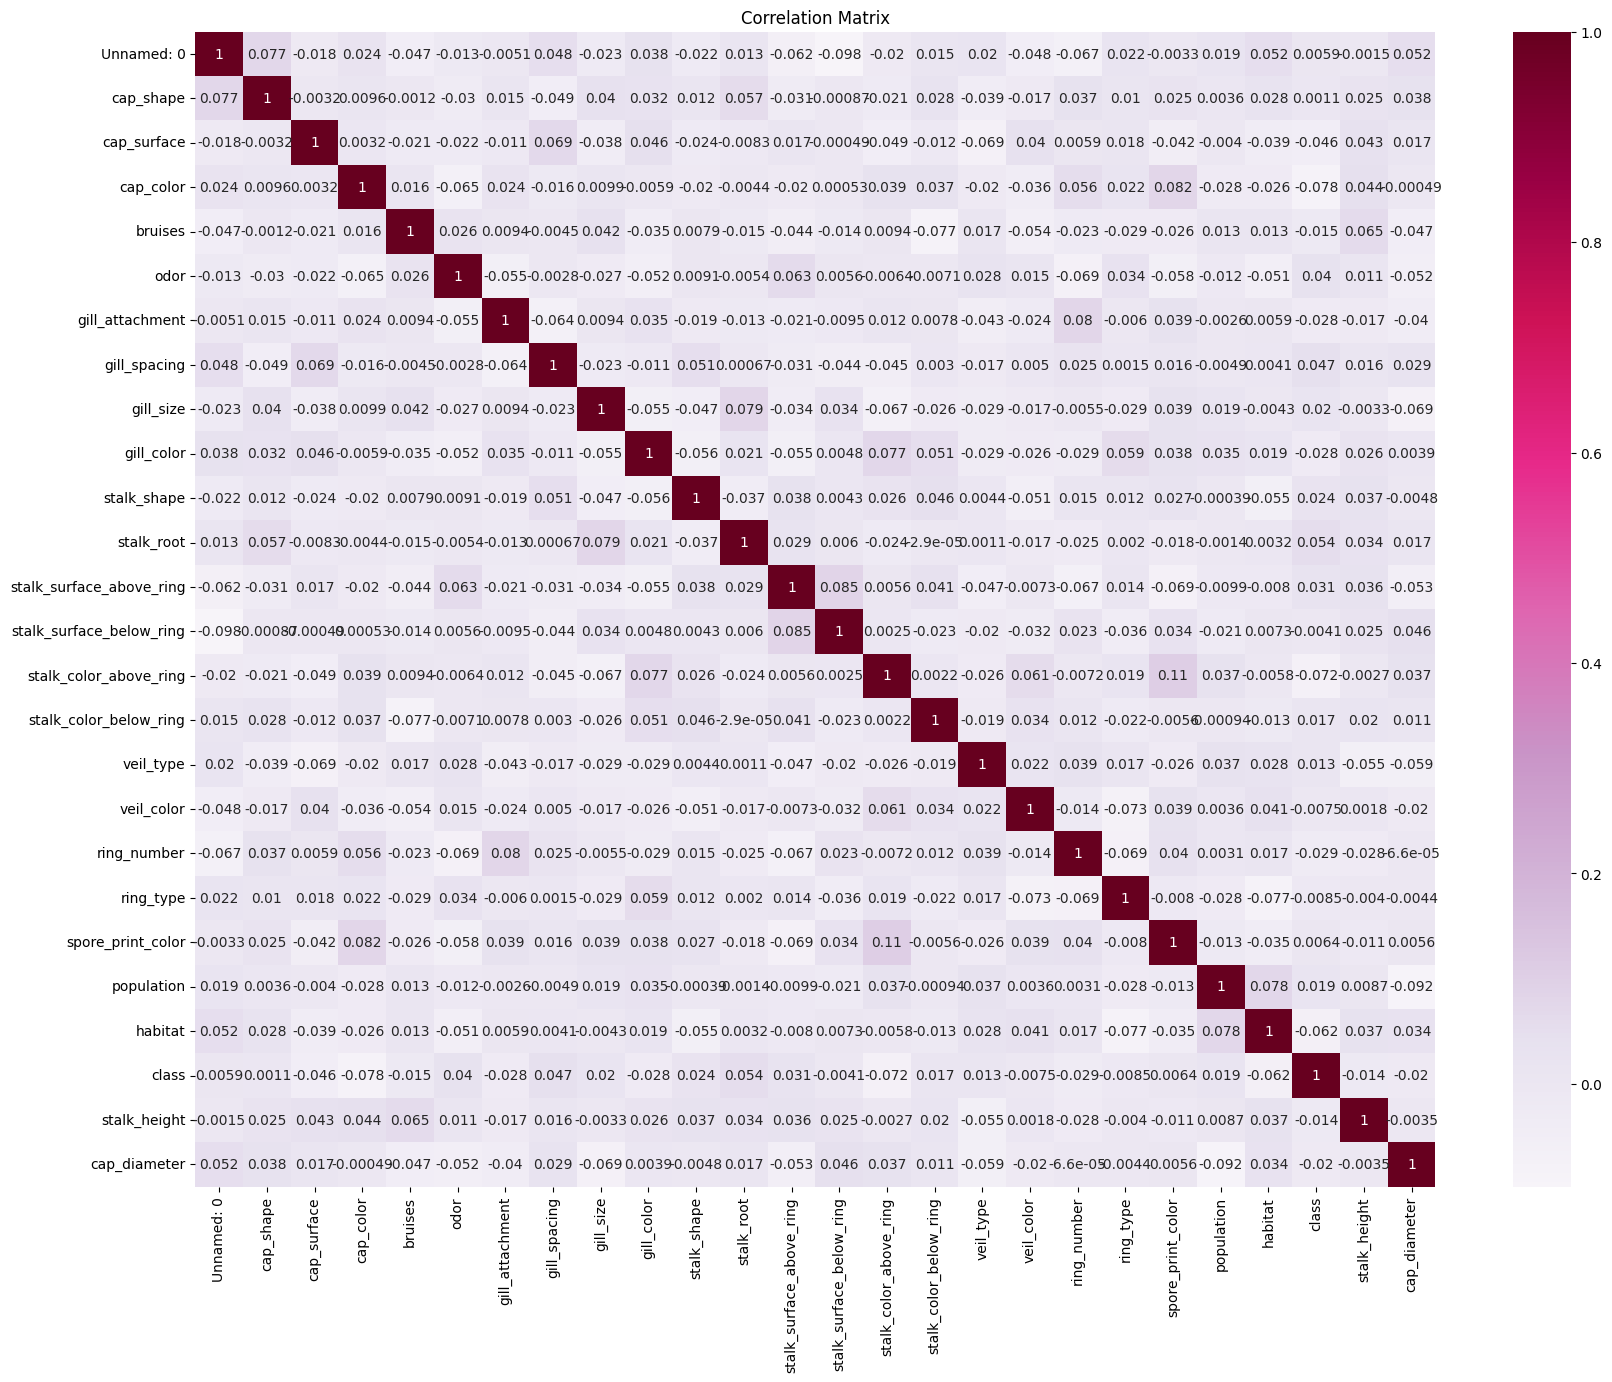

In [15]:
# Correlation Matrix
correlation_matrix = mushrooms.corr()

# Heat Map
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='PuRd')
plt.title('Correlation Matrix')
plt.show()

**Spliting the Dataset into Training and Testing Sets**

In [16]:
# Task 2.2: Split the dataset into training and testing sets
X = mushrooms.drop('class', axis=1)
y = mushrooms['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### SVM Implementation

Implement a basic SVM classifier using Python libraries like scikit-learn

In [18]:
svm = SVC()

# Train the SVM model on the training data
svm.fit(X_train_scaled, y_train)

SVC()

In [19]:
#Evaluate model performance on the testing data using appropriate metrics
y_pred = svm.predict(X_test_scaled)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.38      0.54       133
           1       0.76      0.99      0.86       267

    accuracy                           0.79       400
   macro avg       0.86      0.68      0.70       400
weighted avg       0.83      0.79      0.75       400

[[ 50  83]
 [  2 265]]


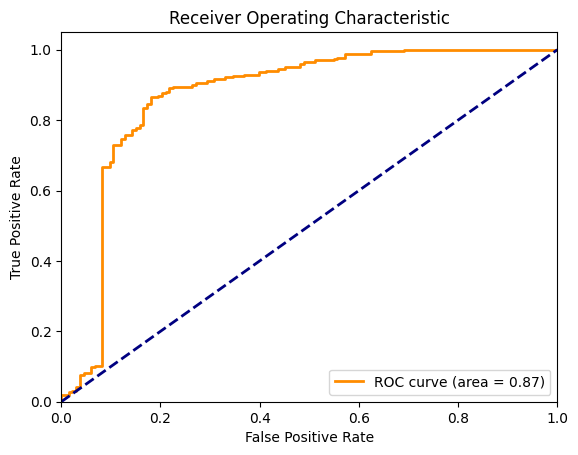

In [20]:
# ROC curve
y_prob = svm.decision_function(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

### Visualization of SVM Results

Since we have many features, we'll visualize only the first two principal components

In [21]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [22]:
svm_pca = SVC()
svm_pca.fit(X_train_pca, y_train)
y_pred_pca = svm_pca.predict(X_test_pca)

In [23]:
# Visualization of SVM Results
def plot_decision_boundary(X, y, model):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
    plt.xlabel('First principal component')
    plt.ylabel('Second principal component')
    plt.title('SVM Results')

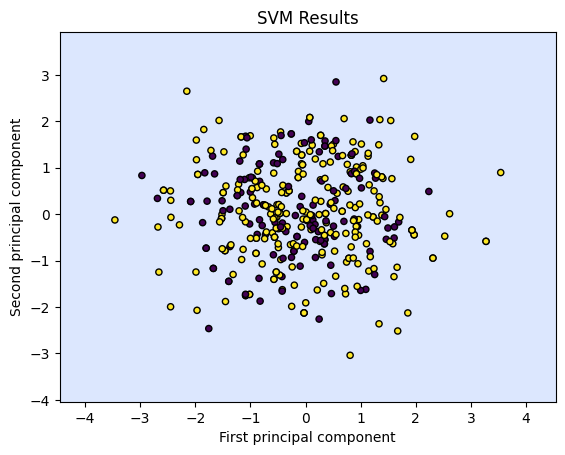

In [24]:
plot_decision_boundary(X_test_pca, y_test, svm_pca)
plt.show()

### Parameter Tuning and Optimization
Grid search for hyperparameter tuning


In [ ]:
# Hyperparameters for SVM
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, cv=3)
grid.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END .....................C=0.1, gamma=1, k

In [55]:
print(f"Best parameters found: {grid.best_params_}")

Best parameters found: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}


In [56]:
best_svm = grid.best_estimator_
y_pred_tuned = best_svm.predict(X_test_scaled)

In [57]:
print(classification_report(y_test, y_pred_tuned))
print(confusion_matrix(y_test, y_pred_tuned))

              precision    recall  f1-score   support

           0       1.00      0.65      0.79       133
           1       0.85      1.00      0.92       267

    accuracy                           0.89       400
   macro avg       0.93      0.83      0.86       400
weighted avg       0.90      0.89      0.88       400

[[ 87  46]
 [  0 267]]


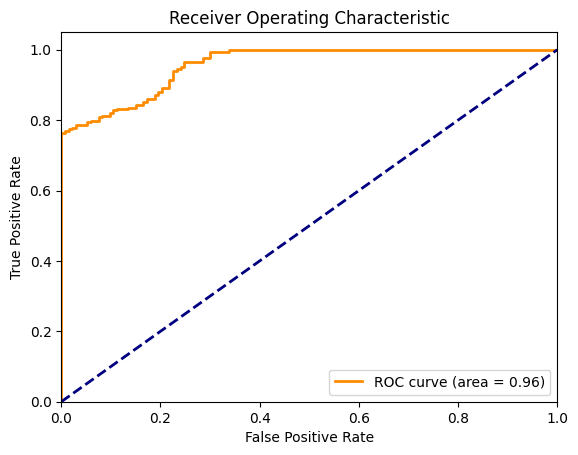

In [58]:
# ROC curve
y_prob_tuned = best_svm.decision_function(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, y_prob_tuned)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

### SVM implemenation on balanced data

In [28]:
# Addressing class imbalance using SMOTE
smote = SMOTE(random_state=42)
smote_enn = SMOTEENN(smote=smote, random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

In [31]:
# Implement a best SVM classifier found above on balanced data
svm_balanced = SVC(kernel='rbf', C=1, gamma=1)

# Task 4.2: Train the SVM model on the training data
svm_balanced.fit(X_train_resampled, y_train_resampled)

SVC(C=1, gamma=1)

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       133
           1       1.00      0.31      0.47       267

    accuracy                           0.54       400
   macro avg       0.71      0.66      0.53       400
weighted avg       0.81      0.54      0.51       400

[[133   0]
 [184  83]]


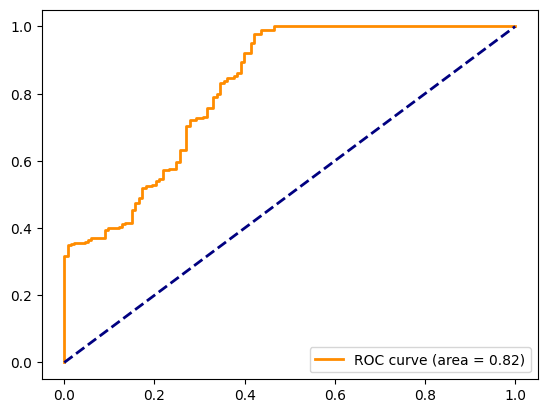

In [32]:
y_pred_balanced = svm_balanced.predict(X_test_scaled)
print(classification_report(y_test, y_pred_balanced))
print(confusion_matrix(y_test, y_pred_balanced))

y_prob_balanced = svm_balanced.decision_function(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, y_prob_balanced)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc='lower right')
plt.show()
print()

### Comparison and Analysis

**Comparision of SVM performance with various kernels**

Kernel: linear
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       133
           1       0.67      1.00      0.80       267

    accuracy                           0.67       400
   macro avg       0.33      0.50      0.40       400
weighted avg       0.45      0.67      0.53       400

[[  0 133]
 [  0 267]]
Kernel: poly
              precision    recall  f1-score   support

           0       0.82      0.74      0.77       133
           1       0.88      0.92      0.90       267

    accuracy                           0.86       400
   macro avg       0.85      0.83      0.84       400
weighted avg       0.86      0.86      0.86       400

[[ 98  35]
 [ 22 245]]
Kernel: rbf
              precision    recall  f1-score   support

           0       1.00      0.65      0.79       133
           1       0.85      1.00      0.92       267

    accuracy                           0.89       400
   macro avg       0.93      0.83      0.8

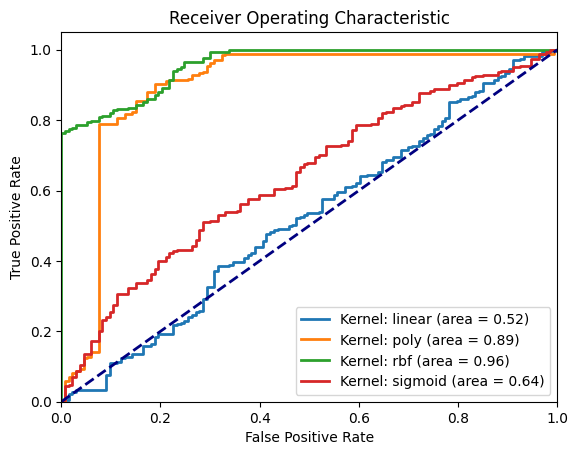

In [33]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
plt.figure()

for kernel in kernels:
    svm_kernel = SVC(kernel=kernel, C=1, gamma=1, probability=True)
    svm_kernel.fit(X_train_scaled, y_train)
    y_pred_kernel = svm_kernel.predict(X_test_scaled)
    print(f"Kernel: {kernel}")
    print(classification_report(y_test, y_pred_kernel))
    print(confusion_matrix(y_test, y_pred_kernel))
    y_prob_kernel = svm_kernel.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob_kernel)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Kernel: {kernel} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

### **Conclusions**

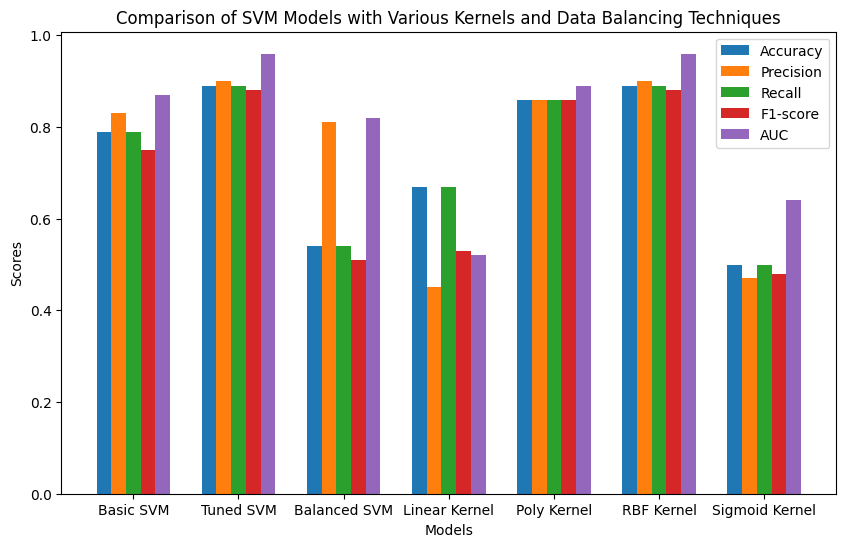

In [35]:
# Define the metrics for each model
models = ['Basic SVM', 'Tuned SVM', 'Balanced SVM', 'Linear Kernel', 'Poly Kernel', 'RBF Kernel', 'Sigmoid Kernel']
accuracies = [0.79, 0.89, 0.54, 0.67, 0.86, 0.89, 0.50]
precisions = [0.83, 0.90, 0.81, 0.45, 0.86, 0.90, 0.47]
recalls = [0.79, 0.89, 0.54, 0.67, 0.86, 0.89, 0.50]
f1_scores = [0.75, 0.88, 0.51, 0.53, 0.86, 0.88, 0.48]
aucs = [0.87, 0.96, 0.82, 0.52, 0.89, 0.96, 0.64]

# Set up the bar width and positions
bar_width = 0.14
index = np.arange(len(models))

# Plotting the metrics
fig, ax = plt.subplots(figsize=(10, 6))

# Bar plots for each metric
bar1 = ax.bar(index, accuracies, bar_width, label='Accuracy')
bar2 = ax.bar(index + bar_width, precisions, bar_width, label='Precision')
bar3 = ax.bar(index + 2 * bar_width, recalls, bar_width, label='Recall')
bar4 = ax.bar(index + 3 * bar_width, f1_scores, bar_width, label='F1-score')
bar5 = ax.bar(index + 4 * bar_width, aucs, bar_width, label='AUC')

# Adding labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of SVM Models with Various Kernels and Data Balancing Techniques')
ax.set_xticks(index + 2 * bar_width)
ax.set_xticklabels(models)
ax.legend()

# Show the plot
plt.show()

### **Analysis:**
- The basic SVM model shows high precision for Class 0 but significantly lower recall, indicating that the model struggles to correctly identify Class 0 instances. For Class 1, the model performs better with high recall, correctly identifying most instances of Class 1.
- The AUC of 0.87 suggests that the model has a good overall performance but is not perfect.
- After hyperparameter tuning, the model's performance improved significantly, especially in terms of recall for Class 0, and precision and recall for Class 1.
- The AUC increased to 0.96, indicating excellent model performance.
- Balancing the data led to a drastic drop in overall accuracy and F1-Score, indicating potential overfitting or poor model performance on the balanced data.
- The recall for Class 0 improved significantly, but precision for Class 1 decreased, suggesting that balancing data might not always yield better results in this case.
- The linear kernel performs poorly with Class 0, leading to zero precision and recall, indicating that it fails to classify Class 0 instances. However, it performs well with Class 1.
- The polynomial kernel provides a balanced performance across both classes with good precision and recall. It is one of the better-performing kernels in this scenario.
- The RBF kernel shows the best performance among all kernels with high precision, recall, and AUC. It effectively classifies both classes with high accuracy.
- The sigmoid kernel performs poorly compared to the other kernels, especially for Class 0. It has the lowest AUC and accuracy, indicating that it is not suitable for this dataset.

### **Summary**
- The **RBF kernel** is the best-performing kernel for this dataset, providing high precision, recall, and AUC.
- The **Polynomial kernel** also performs well, showing a balanced trade-off between precision and recall.
- The **Linear kernel** and **Sigmoid kernel** perform poorly, with significant issues in classifying Class 0.
- **Data balancing** techniques can lead to decreased model performance in certain scenarios, indicating the need for careful evaluation of such methods.

This analysis highlights the strengths and weaknesses of various SVM configurations and kernel functions for the Mushroom dataset, helping in selecting the best model for practical applications.

### Practical Implications of SVM in Real-World Classification Tasks

Support Vector Machines (SVM) are powerful and versatile classifiers used in various real-world applications. Here, we discuss their practical implications and considerations:

**Versatility Across Different Domains** <br>
SVMs are effective in high-dimensional spaces, making them suitable for text classification (e.g., spam detection, sentiment analysis) and image classification tasks. Their ability to handle non-linear relationships through kernel functions expands their applicability to complex datasets.

**Handling Non-Linearly Separable Data**<br>
One of the key strengths of SVMs is their capability to handle non-linearly separable data using the kernel trick. This allows SVMs to map input features into high-dimensional spaces where a linear decision boundary can be established. For example, in bioinformatics, SVMs are used to classify gene expressions and protein sequences where the relationships between features are complex.

**Robustness to Overfitting**<br>
SVMs are less prone to overfitting, particularly in cases with a large number of features relative to the number of samples. This is achieved through the regularization parameter \( C \) and by maximizing the margin between classes. This property is beneficial in fields like finance for credit scoring, where the model needs to generalize well on unseen data.

**Effectiveness with Small to Medium-Sized Datasets**<br>
SVMs perform well with small to medium-sized datasets. For very large datasets, the training time can become computationally intensive, which might necessitate the use of approximation techniques or alternative algorithms.

**Interpretability and Model Selection**<br>
SVMs offer a degree of interpretability, especially with linear kernels, where the model's coefficients can provide insights into the importance of different features. However, the choice of kernel and hyperparameters can significantly impact performance, making model selection and tuning crucial.

**Applications in Real-Time Systems**<br>
For real-time applications like intrusion detection systems or medical diagnosis, SVMs can provide quick predictions once trained, though the training phase itself may be resource-intensive.

**Scalability and Computational Resources**<br>
While SVMs can be computationally expensive, especially with large datasets, efficient implementations and techniques such as stochastic gradient descent or approximate methods can mitigate these challenges. For large-scale applications, the trade-off between accuracy and computational resources must be carefully managed.

### Conclusion
SVMs are a robust tool for classification tasks across various domains. Their effectiveness in handling complex, high-dimensional data and non-linear relationships makes them valuable in practical scenarios. However, consideration of computational resources and proper model tuning is essential to harness their full potential.

